In [99]:
import pandas as pd
import json
import os
from os import listdir
from os.path import isfile, join
import ast
import numpy as np
import stanza
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

#stanza.download('da')

In [100]:
import_cols = ['created_at', 'id', 'full_text', 'entities', 'user', 'retweeted_status', 'is_quote_status', 'retweet_count', 
            'favorite_count', 'favorited', 'retweeted']

user_infos = ['id', 'name', 'screen_name', 'location', 'description', 'url', 'followers_count', 'created_at', 'verified']

keep_cols = ['created_at', 'id', 'full_text', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted',
            'is_retweet', 'hashtags', 'user_mentions', 'urls'] + ["user_" + user_info for user_info in user_infos]

#savepath = os.path.join('C:/', 'data', 'poltweets', "tweets_flattened_20200127.gz")
datapath = os.path.join('C:/', 'data', 'poltweets', "tweets_flattened_20200127.gz")
matpath = os.path.join('..','..', 'material')

In [101]:
nlp = stanza.Pipeline('da', processors = 'tokenize,pos') # no sentiment analysis for Danish

2021-02-05 10:59:30 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |

2021-02-05 10:59:30 INFO: Use device: cpu
2021-02-05 10:59:30 INFO: Loading: tokenize
2021-02-05 10:59:30 INFO: Loading: pos
2021-02-05 10:59:31 INFO: Done loading processors!


In [102]:
# Load data
data = pd.read_csv(datapath, index_col = 0)

In [103]:
# Politicians
polparty = pd.read_csv(os.path.join(matpath, 'politicians_party.csv'))
poldict = polparty.groupby('navn')['parti'].apply(list).to_dict()

In [104]:
# Functions

def get_party(user):
    """
    Find political party based on fuzzy string matching on name.
    """
    similarity = 0

    for k,v in poldict.items():
        newsim = fuzz.ratio(user, k)
        if newsim > similarity:
            similarity = newsim
            party = v[0]
    return(party)

def tokenizer_custom(text):
    """
    Tokenizer function.
    """
    doc = nlp(text)
    
    tag_match = re.compile(r'(?!^\@|^\#)')
    
    pos_tags = ['ADJ', 'NOUN'] # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.pos in pos_tags:
                token = word.text.lower() # Returning the lemma of the word in lower-case.
                tokens.append(token)
    
    tokens = list(filter(tag_match.match, tokens))
    
    return(tokens)

In [105]:
# Adding party variable

users = list(data['user_name'].unique())

userparty = pd.DataFrame({'username': pd.Series(users), 'party': pd.Series(users).apply(get_party)})
userparty_dict = dict(zip(userparty['username'], userparty['party']))

data['party'] = data['user_name'].copy().replace(userparty_dict)

In [106]:
# Formating date variable

data['created_at'] = pd.to_datetime(data['created_at'], format = "%a %b %d %H:%M:%S %z %Y")

In [107]:
# Creating sample

sample = data.loc[data['is_retweet'] == False,:].sample(n = 10000, random_state = 42).reset_index(drop = True)

def climate_match(string):
    regex = re.compile(r'.*klima.*|.*miljø.*', re.IGNORECASE)
    
    if regex.match(string):
        return True
    else:
        return False

sample['talk_climate'] = sample['full_text'].apply(lambda x: climate_match(x))

df = sample.loc[sample['talk_climate'], :].reset_index(drop = True)

print(df.shape)
df.head()

(303, 23)


,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,...,user_name,user_screen_name,user_location,user_description,user_url,user_followers_count,user_created_at,user_verified,party,talk_climate
0,2018-11-22 09:57:49+00:00,1065544874873823200,Nej Mette F - debatten om kød er ikke hysteris...,False,13,65,False,False,False,"['dkpol', 'dkgreen', 'derforuffe']",...,rasmus nordqvist 🏳️‍🌈,rasmusnordqvist,Copenhagen,"Natur, landbrug & fiskeri, Int. udvikling, med...",https://t.co/Rb6deTVKUq,9926,Mon Jan 28 12:47:09 +0000 2013,True,Socialistisk Folkeparti,True
1,2019-12-22 09:46:56+00:00,1208685341315682300,Ja tak - klimaafgifter ligger lige for også på...,True,7,45,False,False,False,"['dkpol', 'dkklima']",...,rasmus nordqvist 🏳️‍🌈,rasmusnordqvist,Copenhagen,"Natur, landbrug & fiskeri, Int. udvikling, med...",https://t.co/Rb6deTVKUq,9926,Mon Jan 28 12:47:09 +0000 2013,True,Socialistisk Folkeparti,True
2,2019-02-26 21:29:22+00:00,1100508144311128000,"@larsloekke sagde i 2014 at det var både ""urea...",False,2,10,False,False,False,"['dkpol', 'dkgreen']",...,Jens Joel,Jens_Joel,NaN,"Folketingsmedlem (S). Bor i Aarhus, valgt i Øs...",https://t.co/YxDz9dEgjd,7295,Tue Mar 15 16:10:47 +0000 2011,False,Socialdemokratiet,True
3,2020-06-06 21:42:10+00:00,1269384108423155700,"Det er som om nogle tror, at de menneskeskabte...",True,15,179,False,False,False,['dkpol'],...,Jacob Mark,jacobmark_sf,NaN,Gruppeformand for SF. Børne- og undervisningso...,NaN,12946,Sat Mar 01 16:04:14 +0000 2014,True,Socialistisk Folkeparti,True
4,2018-06-27 07:53:22+00:00,1011880149313302500,@TheDorteOlsen @nielscallesoe @MonbergSF @Fabu...,False,0,1,False,False,False,[],...,Karsten Hønge,khoenge,NaN,Verbal nævefighter. Politik skal ikke være unø...,https://t.co/ovpq2ryxpX,7492,Sat Jan 25 20:35:49 +0000 2014,True,Socialistisk Folkeparti,True


In [42]:
# Tokenizing

df['tokens'] = df['full_text'].apply(tokenizer_custom)

In [176]:
# Tweets over time

df2 = df.copy()
df2_grouped = df2.groupby(pd.PeriodIndex(data=df['created_at'], freq='D'))
results = df2_grouped.size().to_frame(name = 'count')
idx = pd.period_range(min(results.index), max(results.index))
results = results.reindex(idx, fill_value = 0)
results['year_week'] = results.index.to_timestamp()
results['year_week'] = results['year_week'].dt.year.astype(str) + "-" + results['year_week'].dt.isocalendar().week.astype(str).str.pad(width = 2, fillchar = '0')

week_counts = results.loc[results['year_week'] > '2014-52'].groupby('year_week')['count'].sum().to_frame(name = 'count').reset_index()

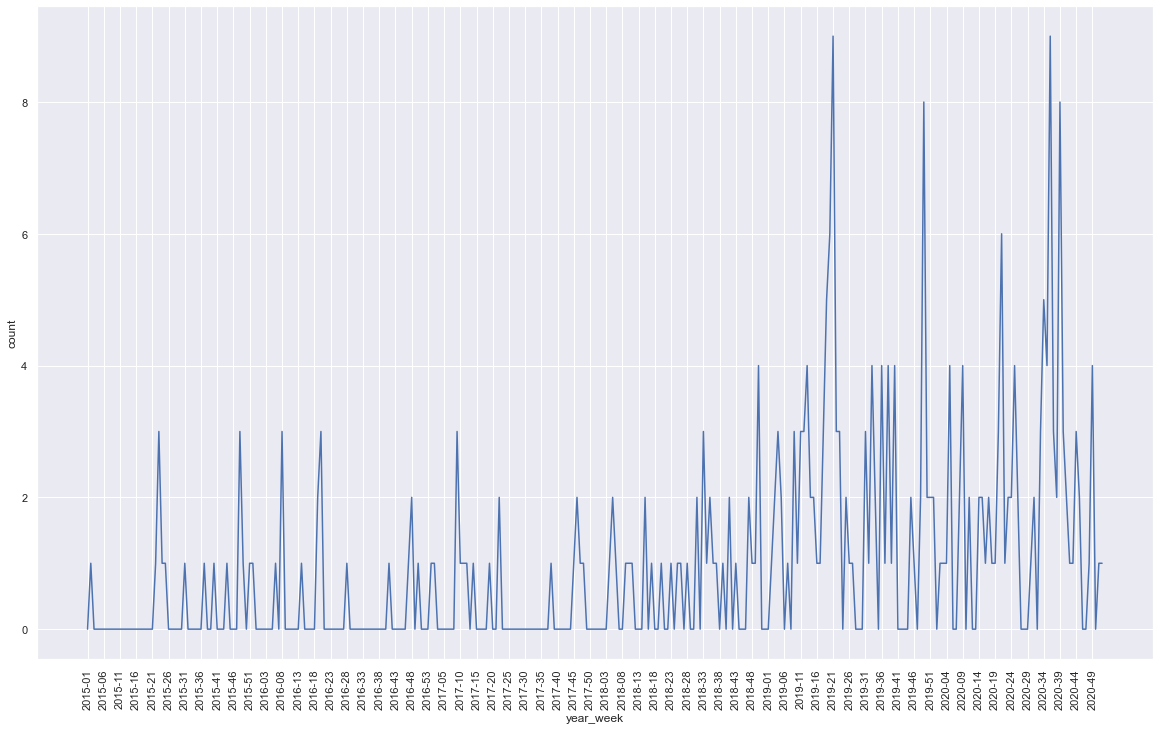

In [177]:
sns.lineplot(data = week_counts, x = 'year_week', y = 'count')
locs, labels = plt.xticks()
plt.xticks(ticks = locs[::5], rotation = 90)
plt.show()

**To do**

- Hvilke partier tweeter mest om klima?
- Mest brugte ord i forbindelse med klima?
    - Udvikling over tid
    - Visualisering? - hvordan? (ordsky, netværk)
- Engagement-variabel (retweet + favorites)
- Inklusion af bestemte ords betydning for engagemenet?